In [1]:
%load_ext autoreload 
%autoreload 2

import os
import random
from collections import deque
import numpy as np
import scipy.linalg as sl
from PIL import Image
import matplotlib as mpl
from matplotlib import pyplot as plt
import seaborn as sns
from IPython import display

import torch
from torch import nn, distributions as dist, autograd
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, CenterCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)
plt.style.use('seaborn-v0_8')

from mnist import MNISTTrain, MNISTTest

/env_dl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
img_size = 28
batch_size = 512
num_classes = 10
zdim = 50

In [3]:
train_ds = MNISTTrain(transform=Compose([
    ToTensor(),
    # RandomHorizontalFlip(0.1),
    # RandomVerticalFlip(0.1),
    Normalize(127., 128.0)
]))
val_ds = MNISTTest(transform=Compose([
    ToTensor(),
    Normalize(127., 128.0)
]))


In [4]:
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, drop_last=True)

In [5]:
next(iter(train_loader))[0].aminmax()

torch.return_types.aminmax(
min=tensor(-0.9922),
max=tensor(1.))

In [6]:
class Upsample(nn.Module):
    
    def __init__(self, in_channels, out_channels, kernel_size=3, 
                stride=2, padding=0, outpout_padding=0):
        super().__init__()
        self.conv = nn.ConvTranspose2d(in_channels, 
                                       out_channels, 
                                       kernel_size=kernel_size, 
                                       stride=stride, 
                                       padding=padding,
                                       output_padding=outpout_padding
                                       )
        self.bn = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.activation(x)
        return x

class Generator(nn.Module):
    
    def __init__(self, zdim=64):
        super().__init__()
        self.zdim = zdim
        self.dense = nn.Linear(zdim, 7*7*128)
        self.act1 = nn.LeakyReLU()
        
        self.upsample2 = Upsample(128, 64, kernel_size=3, padding=1, stride=1)
        self.upsample3 = Upsample(64, 32, kernel_size=3, padding=1, stride=2, outpout_padding=1)
        self.upsample4 =nn.ConvTranspose2d(32, 
                                       1, 
                                       kernel_size=3, 
                                       stride=2, 
                                       padding=1,
                                       output_padding=1
                                       )
        self.normalizer = nn.Tanh()
        
    def forward(self, z):
        x = self.dense(z)
        x = self.act1(x)
        x = x.view((x.size(0), 128, 7, 7,))
        x = self.upsample2(x)
        x = self.upsample3(x)
        x = self.upsample4(x)
        x = self.normalizer(x)
        return x


class Discriminator(nn.Module):
    
    def __init__(self, eps=1e-5):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding="same"),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.1),
            
            
            nn.Conv2d(64, 32, 3, stride=2, padding=1),
        
        )

        self.dense = nn.Sequential(
            nn.Linear( 1568, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 1),
        )
        self.eps = eps
        
    def forward(self, x):
        x = self.net(x)
        x = x.view((x.size(0), -1))
        x = self.dense(x)
        return x
    
# Generator()(torch.randn((2, 64))).size()
Discriminator()(torch.randn((2, 1, 28, 28))).size()

torch.Size([2, 1])

In [7]:
class GanTrainer:
    
    def __init__(self, 
                 train_loader, 
                 val_loader=None, 
                 epochs=0,
                 zdim=50, 
                 dsteps=10,
                 savepath=None, 
                 batch_size=1,
                 eval_epoch=1000000,
                 device=torch.device("cuda")
                 ):
        self.gmodel = Generator(zdim)
        self.dmodel = Discriminator()
        if device.type == "cuda":
            self.gmodel.cuda()
            self.dmodel.cuda()
            
        self.train_loader = train_loader
        self.val_loader = val_loader
        
        self.epochs = epochs
        self.batch_size = batch_size
        self.eval_epoch = eval_epoch
        self.dsteps = dsteps
        self.zdim = zdim
        self.device = device
        self.n_samples = 0
        
        self.doptimizer = torch.optim.Adam(self.dmodel.parameters(), lr=1e-5)    
        self.goptimizer = torch.optim.Adam(self.gmodel.parameters(), lr=1e-4)  
        
        self.noise_sampler = dist.Normal(0., 1.)
        self.test_images_z = self.noise_sampler.sample((64, zdim)).to(self.device).detach()
        
        self.savepath = savepath
        if self.savepath is not None:
            os.makedirs(self.savepath, exist_ok=True)
        
    def fit(self, epoch, loader):
        losses = {"generator": [], "discriminator": []}
        self.gmodel.train()
        self.dmodel.train()
        for step, (imgs, label) in enumerate(loader):
            gen_is_training = step > 0 and step % self.dsteps == 0
            
            noise_z = self.get_noise_sample()
            
            fake_imgs = self.gmodel(noise_z)
            
            real_imgs = imgs.to(self.device)
            
            disc_real_out = self.dmodel(real_imgs)
            disc_fake_out = self.dmodel(fake_imgs)
            
            real_labels = disc_real_out.new_ones((disc_real_out.size(0), 1))
            fake_labels = disc_fake_out.new_zeros((disc_fake_out.size(0), 1))
            
            
            disc_loss = (
                F.binary_cross_entropy_with_logits(disc_real_out, real_labels) +
                F.binary_cross_entropy_with_logits(disc_fake_out, fake_labels)
                )
            
            self.doptimizer.zero_grad()
            self.goptimizer.zero_grad()
            disc_loss.backward()
            torch.nn.utils.clip_grad_norm_(self.dmodel.parameters(), 1.)
            self.doptimizer.step()
            
            self.doptimizer.zero_grad()
            self.goptimizer.zero_grad()
            losses["discriminator"].append(float(disc_loss))
            
            if gen_is_training:
            
                noise_z = self.get_noise_sample()
                fake_imgs = self.gmodel(noise_z)
                disc_fake_out = self.dmodel(fake_imgs)
                gen_loss =  F.binary_cross_entropy_with_logits(disc_fake_out, real_labels)
                
                gen_loss.backward()
                torch.nn.utils.clip_grad_norm_(self.gmodel.parameters(), 1.)

                self.goptimizer.step()
                losses["generator"].append(float(gen_loss))
                
            
            
            if step % 30 == 0:
                print(f"Epoch: {epoch}, step: {step}, dloss: {np.mean(losses['discriminator'])}, gloss: {np.mean(losses['generator'])}")
                self.generate_imgs()
        return losses
    
    def get_noise_sample(self, sample_size=-1):
        if sample_size == -1:
            sample_size = self.batch_size
        zsamples = self.noise_sampler.sample((sample_size, self.zdim)).to(self.device)
        return zsamples
        
    def train(self):
        self.train_losses = {"generator": [], "discriminator": []}
        for epoch in range(1, self.epochs + 1):
            losses = self.fit(epoch, train_loader)
            self.train_losses["discriminator"].extend(losses["discriminator"])
            self.train_losses["generator"].extend(losses["generator"])
            if epoch % self.eval_epoch == 0:
                # self.evaluate(epoch)
                self.generate_imgs( )
        self.generate_imgs()
        return 
    
    def generate_imgs(self):
        savepath = os.path.join(self.savepath, f"samples{self.n_samples}")
        os.makedirs(savepath, exist_ok=True)
        nsample = self.test_images_z.size(0)
        self.gmodel.eval()
        with torch.no_grad():
            xgen = self.gmodel(self.test_images_z)
            
            imgs = xgen.permute((0, 2, 3, 1))
            imgs = imgs.squeeze(-1)
            
            imgs *= 128.
            imgs += 127.
            
            imgs = list(imgs.unbind())
            for n in range(nsample):
                fname = os.path.join(savepath, f"img{n}.jpeg")
                imgs[n] = imgs[n].detach().cpu().long().numpy().astype(np.uint8)
                
                self.save_img(imgs[n], fname)
        self.gmodel.train()

        self.n_samples += 1
    
    def save_img(self, imgs, fname):
        Image.fromarray(imgs, mode="L").resize((128, 128)).save(fname)

In [8]:
trainer = GanTrainer(
                 train_loader, 
                 val_loader=val_loader, 
                 zdim=64, 
                 dsteps=10,
                 savepath="/mnt/dl/generation/gan3", 
                 batch_size=batch_size,
                 device=torch.device("cuda"),
                 epochs=50,
                 eval_epoch=1,
                 
                 )

In [9]:
trainer.train()

/env_dl/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/env_dl/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch: 1, step: 0, dloss: 1.3894147872924805, gloss: nan
Epoch: 1, step: 30, dloss: 1.3363670687521658, gloss: 0.7409677108128866
Epoch: 1, step: 60, dloss: 1.2796921124223803, gloss: 0.7673113445440928
Epoch: 1, step: 90, dloss: 1.2161910900702844, gloss: 0.8064155247476366
Epoch: 1, step: 120, dloss: 1.1467749427172764, gloss: 0.8617846171061198
Epoch: 1, step: 150, dloss: 1.0742276393814592, gloss: 0.9307865063349406
Epoch: 1, step: 180, dloss: 1.0015955666152154, gloss: 1.0113513602150812
Epoch: 1, step: 210, dloss: 0.9306469477748419, gloss: 1.101583446775164
Epoch: 1, step: 240, dloss: 0.8625262110065128, gloss: 1.203839510679245
Epoch: 1, step: 270, dloss: 0.7981945926742801, gloss: 1.318693266974555
Epoch: 1, step: 300, dloss: 0.7383938691643781, gloss: 1.4472138086954753
Epoch: 1, step: 330, dloss: 0.683659932742126, gloss: 1.58945657267715
Epoch: 1, step: 360, dloss: 0.6342715917160306, gloss: 1.743506173292796
Epoch: 1, step: 390, dloss: 0.5905528676403148, gloss: 1.89815333

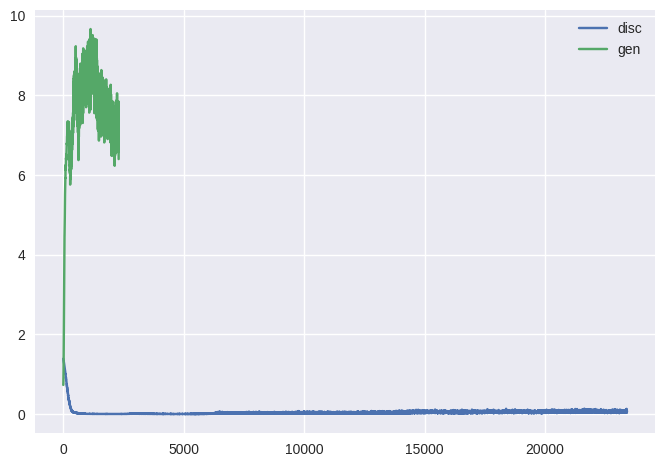

In [10]:
plt.plot(trainer.train_losses["discriminator"], label='disc')
plt.plot(trainer.train_losses["generator"], label='gen')
plt.legend()